## LIBRERIAS

In [75]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import urllib.request
import warnings
warnings.filterwarnings('ignore')


### DESCARGAR DATOS Y LECTURA DE ARCHIVOS

In [76]:
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True) 

# URLs de los archivos
URLS = {
    'sellin': ('sell-in.txt.gz', 'https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/sell-in.txt.gz'),
    'productos': ('tb_productos.txt', 'https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/tb_productos.txt'),
    'stocks': ('tb_stocks.txt', 'https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/tb_stocks.txt'),
    'productos_predecir': ('product_id_apredecir201912.txt', 'https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt')
}

for nombre, (archivo, url) in URLS.items():
    path = os.path.join(DATA_DIR, archivo)          # data/archivo
    if not os.path.exists(path):
        print(f"Descargando {nombre} → {path} …")
        urllib.request.urlretrieve(url, path)
        print("descargado")
    else:
        print(f"{archivo} ya existe")


sell-in.txt.gz ya existe
tb_productos.txt ya existe
tb_stocks.txt ya existe
product_id_apredecir201912.txt ya existe


In [77]:
# Lectura
df_sell_in = pd.read_csv('data/sell-in.txt.gz', compression='gzip', sep='\t')
df_productos = pd.read_csv('data/tb_productos.txt', sep='\t')  
df_stocks= pd.read_csv('data/tb_stocks.txt', sep='\t')
df_productos_predecir = pd.read_csv('product_id_apredecir201912.txt', sep='\t', dtype={'product_id': str})

In [78]:
# Dataset 1: granularidad <producto, cliente>
df_producto_cliente_raw = pd.merge(df_sell_in, df_productos, on='product_id', how='left')

# filtro productos a predecir
productos_a_predecir = df_productos_predecir['product_id'].astype(int).unique()

df_producto_cliente = df_producto_cliente_raw[df_producto_cliente_raw['product_id'].isin(productos_a_predecir)].copy()

# Creo timestamp
df_producto_cliente["timestamp"] = (
    pd.to_datetime(df_producto_cliente["periodo"].astype(str), format="%Y%m")
      .dt.to_period("M") 
      .dt.to_timestamp()
)

# ahorro ram
df_producto_cliente = df_producto_cliente.astype({
    "customer_id":            "int32",
    "product_id":             "int32",
    "plan_precios_cuidados":  "int8",
    "cust_request_qty":       "int32",
    "cust_request_tn":        "float32",
    "tn":                     "float32",
})

STATIC_COLS = ["cat1","cat2","cat3","brand","sku_size","descripcion"]
for col in STATIC_COLS:
    if col in df_producto_cliente.columns:
        df_producto_cliente[col] = df_producto_cliente[col].fillna("Unknown")

In [79]:
print(df_producto_cliente.shape)
df_producto_cliente.head()

(2293481, 14)


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,timestamp
0,201701,10234,20524,0,2,0.05300,0.05300,HC,VAJILLA,Cristalino,Importado,500.0,Abrillantador,2017-01-01
1,201701,10032,20524,0,1,0.13628,0.13628,HC,VAJILLA,Cristalino,Importado,500.0,Abrillantador,2017-01-01
2,201701,10217,20524,0,1,0.03028,0.03028,HC,VAJILLA,Cristalino,Importado,500.0,Abrillantador,2017-01-01
3,201701,10125,20524,0,1,0.02271,0.02271,HC,VAJILLA,Cristalino,Importado,500.0,Abrillantador,2017-01-01
4,201701,10012,20524,0,11,1.54452,1.54452,HC,VAJILLA,Cristalino,Importado,500.0,Abrillantador,2017-01-01


In [80]:
# Dataset 2: granularidad <producto>
# partimos del dataframe granular (cliente-producto)

# columnas numéricas que deseamos sumar (toneladas, cantidades, etc.)
cols_sum = ["tn"]

# columnas categóricas/estáticas que son iguales para cada product_id;
# basta con tomar la primera aparición tras el groupby
cols_first = ["cat1", "cat2", "cat3", "brand", "sku_size", "descripcion"]

# flag "plan_precios_cuidados": tomamos el valor máximo
cols_max = ["plan_precios_cuidados"]

# agregamos por periodo y product_id
df_producto = (
    df_producto_cliente
      .groupby(["timestamp", "product_id"], as_index=False)
      .agg({**{c: "sum"  for c in cols_sum},
            **{c: "first" for c in cols_first},
            **{c: "max"  for c in cols_max}})
      .sort_values(['product_id', 'timestamp'])
)

# vuelvo a generar columna original
df_producto["periodo"] = df_producto["timestamp"].dt.strftime("%Y%m").astype(int)

print(df_producto.shape)
df_producto.head()

(22349, 11)


,timestamp,product_id,tn,cat1,cat2,cat3,brand,sku_size,descripcion,plan_precios_cuidados,periodo
0,2017-01-01,20001,934.772217,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0,201701
496,2017-02-01,20001,798.016174,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0,201702
994,2017-03-01,20001,1303.357666,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0,201703
1495,2017-04-01,20001,1069.961304,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0,201704
1995,2017-05-01,20001,1502.201294,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0,201705


### Análisis de datasets

In [81]:
# ── 1. Distribución de longitud de serie ────────────────────────────────────
def serie_length_stats(df, by_cols):
    longitudes = df.groupby(by_cols)["tn"].size()
    print(f"\n Longitudes de series por {by_cols}:")
    print(longitudes.describe())
    return longitudes

# ── 2. Proporción de ceros por serie ────────────────────────────────────────
def zeros_ratio_stats(df, by_cols):
    ratio = (
        df.groupby(by_cols)["tn"]
          .apply(lambda s: (s == 0).mean())
    )
    print(f"\n Proporción de ceros por {by_cols}:")
    print(ratio.describe())
    return ratio

# ── 3. Volumen total por serie (cuartiles) ──────────────────────────────────
def volume_stats(df, by_cols):
    vols = df.groupby(by_cols)["tn"].sum()
    print(f"\n Volumen total (tn) por {by_cols}:")
    print(vols.describe())
    return vols

# ── 4. Estacionalidad básica (promedio mensual) ─────────────────────────────
def seasonality_mean(df, label):
    df['month'] = df['timestamp'].dt.month
    print(f"\n📅 Promedio mensual de tn ({label}):")
    print(df.groupby("month")["tn"].mean().round(2))

# ── 5. % de valores faltantes en atributos estáticos ────────────────────────
STATIC_COLS = ["cat1", "cat2", "cat3", "brand", "sku_size", "descripcion"]
def missing_static(df):
    print("\n Porcentaje de valores faltantes en atributos estáticos:")
    print((df[STATIC_COLS].isna().mean() * 100).round(2).sort_values(ascending=False))

# ── 6. Correlación simple entre covariables dinámicas y tn ──────────────────
DYN_COLS = ["plan_precios_cuidados"]   # añade más si tienes
def dynamic_corr(df):
    corr = df[DYN_COLS + ["tn"]].corr()["tn"].drop("tn")
    print("\n Correlación de covariables dinámicas con tn:")
    print(corr.round(3))

# ── 7. Superposición cliente-producto ───────────────────────────────────────
def overlap_stats(df):
    n_clients_per_prod = df.groupby("product_id")["customer_id"].nunique()
    n_prods_per_client = df.groupby("customer_id")["product_id"].nunique()
    print("\n Clientes por producto:")
    print(n_clients_per_prod.describe())
    print("\n Productos por cliente:")
    print(n_prods_per_client.describe())

In [82]:
print("═══════════════════════════════════════════════════════════════════════")
print("ANÁLISIS: df_producto_cliente")
print("═══════════════════════════════════════════════════════════════════════")

serie_length_stats(df_producto_cliente, ["product_id", "customer_id"])
zeros_ratio_stats(df_producto_cliente, ["product_id", "customer_id"])
volume_stats(df_producto_cliente, ["product_id", "customer_id"])
seasonality_mean(df_producto_cliente, "producto-cliente")
missing_static(df_producto_cliente)
dynamic_corr(df_producto_cliente)
overlap_stats(df_producto_cliente)

═══════════════════════════════════════════════════════════════════════
ANÁLISIS: df_producto_cliente
═══════════════════════════════════════════════════════════════════════

 Longitudes de series por ['product_id', 'customer_id']:
count    262805.000000
mean          8.726931
std           8.375365
min           1.000000
25%           2.000000
50%           6.000000
75%          13.000000
max          36.000000
Name: tn, dtype: float64

 Proporción de ceros por ['product_id', 'customer_id']:
count    262805.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: tn, dtype: float64

 Volumen total (tn) por ['product_id', 'customer_id']:
count    262805.000000
mean          4.271627
std          48.403843
min           0.000100
25%           0.024570
50%           0.124290
75%           0.716930
max        7740.341309
Name: tn, dtype: float64

📅 Promedio mensual de tn (producto-cliente):
month
1     0.47
2    

#### 
* las series son cortas: mediana 6 meses, el 75% por debajo de 13 meses.
* no tenemos datos explícitos para meses sin venta (proporción de 0s)
* volúmenes pequeños y asimétricos: mediana en 0.12 y pero casos arriba de 1k
* patrón estacional suave, ligero pico en octubre: 10 - 0.54
* el flag de precios_cuidados no es relevante
* la cobertura de compra es amplia: media de 337 clientes por producto, cada cliente compra 440 productos

* Qué hacer:
- rellenar con ceros donde no hubo ventas (para que el modelo aprenda "demanda nula") -> se decide usar una ventaja fija de 36 meses y no con "meses vivos" (nuevo dataframe)
- entrenar un tft_largo con la vetana de 36 meses esperando capturar ciclos anuales 
- dado el tamaño de las series del dataframe actual, podemos explorar la idea de tft_corto donde vea una ventana de tiempo de 6 meses (evitando series compuestas con 0s)

In [83]:
print("\n\n═══════════════════════════════════════════════════════════════════════")
print("ANÁLISIS: df_producto")
print("═══════════════════════════════════════════════════════════════════════")

serie_length_stats(df_producto, ["product_id"])
zeros_ratio_stats(df_producto, ["product_id"])
volume_stats(df_producto, ["product_id"])
seasonality_mean(df_producto, "producto agregado")
missing_static(df_producto)
dynamic_corr(df_producto)



═══════════════════════════════════════════════════════════════════════
ANÁLISIS: df_producto
═══════════════════════════════════════════════════════════════════════

 Longitudes de series por ['product_id']:
count    780.000000
mean      28.652564
std       11.045410
min        4.000000
25%       21.000000
50%       36.000000
75%       36.000000
max       36.000000
Name: tn, dtype: float64

 Proporción de ceros por ['product_id']:
count    780.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: tn, dtype: float64

 Volumen total (tn) por ['product_id']:
count      780.000000
mean      1439.237305
std       3849.674316
min          0.454470
25%         68.191786
50%        251.167809
75%        840.369736
max      50340.394531
Name: tn, dtype: float64

📅 Promedio mensual de tn (producto agregado):
month
1     45.700001
2     47.910000
3     62.139999
4     51.750000
5     55.480000
6     52.150002
7     47.459999
8     46.2

###
* el 75% de los productos tiene más de 21 meses de historia, por lo que podemos entrenar un tft mirando la serie completa. Pero dado que no hay ceros computados, debemos llenar manualmente (Darts no lo hace)
* Cada producto tiene volúmenes totales heterogéneos, P50: 251, P75: 840, etc
* parece haber una estacionalidad más marcada, con picos en marzo-mayo (65-55 tn) y un valle en diciembre (39 tn)
* por este motivo, si usáramos el dataset mirando la serie únicamente por producto, es recomendable utilizar un input_chunk_size largo (ventanas anuales por lo menos)
* el flag de precios_cuidados no es relevante 

### Nuevos datasets

In [84]:
# armado de dataset con 36 meses fijos para tft_largo
df_cart = df_producto_cliente.copy()

# rango
start = df_cart['timestamp'].min().to_period("M").to_timestamp()
end = df_cart['timestamp'].max().to_period("M").to_timestamp()
months = pd.date_range(start, end, freq="MS")

# pares
pairs = df_cart[["customer_id", "product_id"]].drop_duplicates()
n = len(pairs)

# extendemos los pares
aux = pairs.loc[pairs.index.repeat(len(months))].reset_index(drop=True)
aux["timestamp"] = np.tile(months, n)

# merge
cols_mantener = ["customer_id", "product_id", "timestamp", "tn", "cat1", "cat2", "cat3", "brand"]

out = (
    aux
        .merge(df_cart[cols_mantener],
        how="left",
        on=["customer_id", "product_id", "timestamp"],
        validate="1:1")
)

out["tn"] = out["tn"].fillna(0).astype("float32")
out["is_synth"] = out["tn"].eq(0)

out.to_parquet('data/tft_completo.parquet', compression="zstd")
print(f"Se creó df_cart.parquet con: {(len(out))} filas para tft largo")

Se creó df_cart.parquet con: 9460980 filas para tft largo


NOTA: Para el TFT hemos preferido no generar el cross-join completo (16 M de filas) porque al final evaluamos toneladas por producto y ese exceso de ceros apenas aporta señal adicional para la tarea puntual de Kaggle.
Sin embargo, en un enfoque con árboles de decisión (XGBoost, LightGBM) esos ceros “negativos” pueden ayudar a definir mejor la frontera entre clientes que nunca compran un SKU y aquellos que sí, por lo que en otro pipeline más orientado a clasificación o regresión a nivel cliente-producto podrían resultar útiles.

In [85]:
# tft corto
df_producto_cliente.to_parquet('data/tft_ventana_corta.parquet', compression="zstd")
print(f"Se creó df_producto_cliente.parquet con: {(len(df_producto_cliente))} filas para tft corto")

Se creó df_producto_cliente.parquet con: 2293481 filas para tft corto


In [86]:
df_producto.shape

(22349, 12)

In [87]:
# tft producto completando con 0s
start = pd.to_datetime("201701", format="%Y%m").to_period("M").to_timestamp()
end   = pd.to_datetime("201912", format="%Y%m").to_period("M").to_timestamp()
months = pd.date_range(start, end, freq="MS")  # 36 meses

# Lista de productos en df
productos = df_producto["product_id"].unique()

# indice completo de producto x mes
full_idx = (
    pd.MultiIndex
      .from_product([productos, months], names=["product_id","timestamp"])
      .to_frame(index=False)
)

# join con df_producto
df_producto = (
    full_idx
      .merge(df_producto, on=["product_id","timestamp"], how="left")
)

# rellenamos donde haga falta
df_producto["tn"] = df_producto["tn"].fillna(0).astype("float32")

# Rellena atributos estáticos por producto (ffill/bfill)
STATIC_COLS = ["cat1","cat2","cat3","brand","plan_precios_cuidados"]
for col in STATIC_COLS:
    if col in df_producto:
        df_producto[col] = (
            df_producto
              .groupby("product_id")[col]
              .transform(lambda s: s.ffill().bfill())
        )

# marcamos padding
df_producto["is_synth"] = (df_producto["tn"] == 0)

# esperamos que dé 780x36=28080
df_producto.shape[0]


28080

In [88]:
df_producto.head()

,product_id,timestamp,tn,cat1,cat2,cat3,brand,sku_size,descripcion,plan_precios_cuidados,periodo,month,is_synth
0,20001,2017-01-01,934.772217,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0.0,201701.0,1.0,False
1,20001,2017-02-01,798.016174,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0.0,201702.0,2.0,False
2,20001,2017-03-01,1303.357666,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0.0,201703.0,3.0,False
3,20001,2017-04-01,1069.961304,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0.0,201704.0,4.0,False
4,20001,2017-05-01,1502.201294,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,0.0,201705.0,5.0,False


In [89]:
df_producto.to_parquet('data/tft_agg.parquet', compression="zstd")
print(f"Se creó df_producto.parquet con: {(len(df_producto))} filas para tft extra")

Se creó df_producto.parquet con: 28080 filas para tft extra


#### Otras exploraciones

In [90]:
# 2. Información general
print("Información de columnas y tipos:")
print(df_sell_in.info())
print(df_productos.info())
print(df_stocks.info())

print("\nEstadísticas descriptivas (numéricas):")
print(df_sell_in.describe())
print(df_productos.describe())
print(df_stocks.describe())

print("\nValores faltantes por columna:")
print(df_sell_in.isnull().sum())
print(df_productos.isnull().sum())
print(df_stocks.isnull().sum())

print("\n15 Valores del top")
print(df_sell_in.head(10))
print(df_productos.head(10))

Información de columnas y tipos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(5)
memory usage: 157.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cat1         1251 non-null   object
 1   cat2         1251 non-null   object
 2   cat3         1251 non-null   object
 3   brand        1251 non-null   object
 4   sku_size     1251 non-null   int64 
 5   product_id   1251 non-null   int64 
 6   descripcion  1251 non-null   object

In [91]:
# periodo min para sell_in
print(f"\nPeriodo mínimo para sell_in: {df_sell_in['periodo'].min()}")
# periodo max para sell_in
print(f"\nPeriodo maximo para sell_in: {df_sell_in['periodo'].max()}")

# periodo min para stocks
print(f"\nPeriodo mínimo para stocks: {df_stocks['periodo'].min()}")
# periodo max para sell_in
print(f"\nPeriodo maximo para stocks: {df_stocks['periodo'].max()}")




Periodo mínimo para sell_in: 201701

Periodo maximo para sell_in: 201912

Periodo mínimo para stocks: 201810

Periodo maximo para stocks: 201912


### TENDENCIAS Y DISTRIBUCIONES

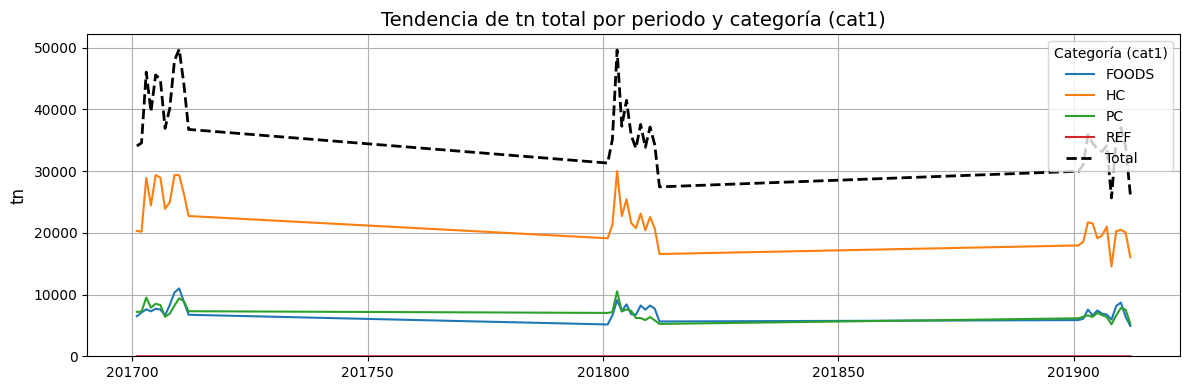

In [92]:
# Agrupar por periodo y cat1, y calcular la suma de tn
period_cat1_tn = df_producto_cliente_raw.groupby(['periodo', 'cat1'])['tn'].sum().reset_index()

# Calcular el total de tn por periodo
period_total_tn = df_producto_cliente_raw.groupby('periodo')['tn'].sum().reset_index()


# Crear el gráfico
plt.figure(figsize=(12, 4))

# Graficar una línea para cada categoría en cat1
for cat in period_cat1_tn['cat1'].unique():
    data = period_cat1_tn[period_cat1_tn['cat1'] == cat]
    plt.plot(data['periodo'], data['tn'], label=cat)


# Graficar la línea del total
plt.plot(period_total_tn['periodo'], period_total_tn['tn'], label='Total', color='black', linewidth=2, linestyle='--')

# Configurar etiquetas y título
plt.title('Tendencia de tn total por periodo y categoría (cat1)', fontsize=14)
plt.ylabel('tn', fontsize=12)
plt.ylim(bottom=0)
plt.legend(title='Categoría (cat1)')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


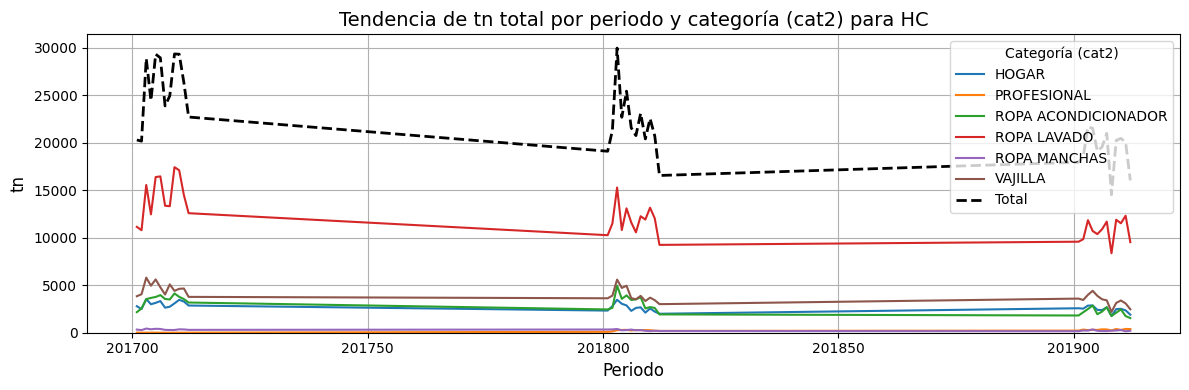

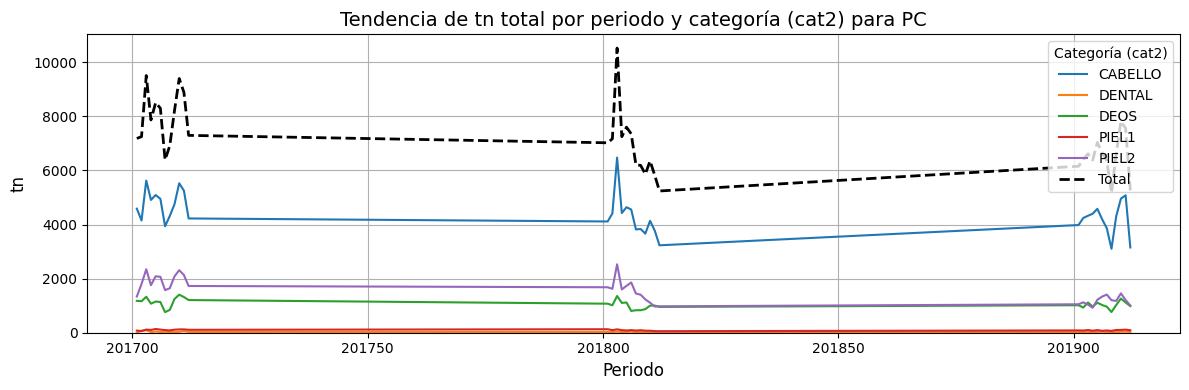

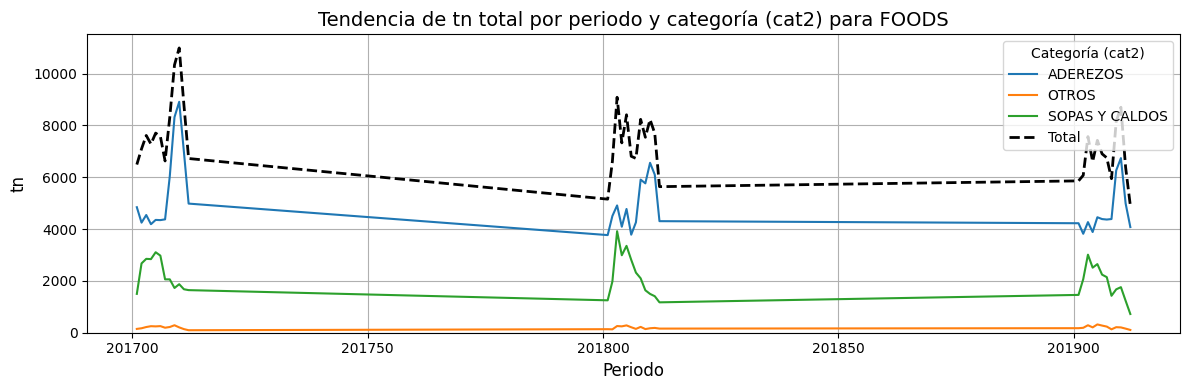

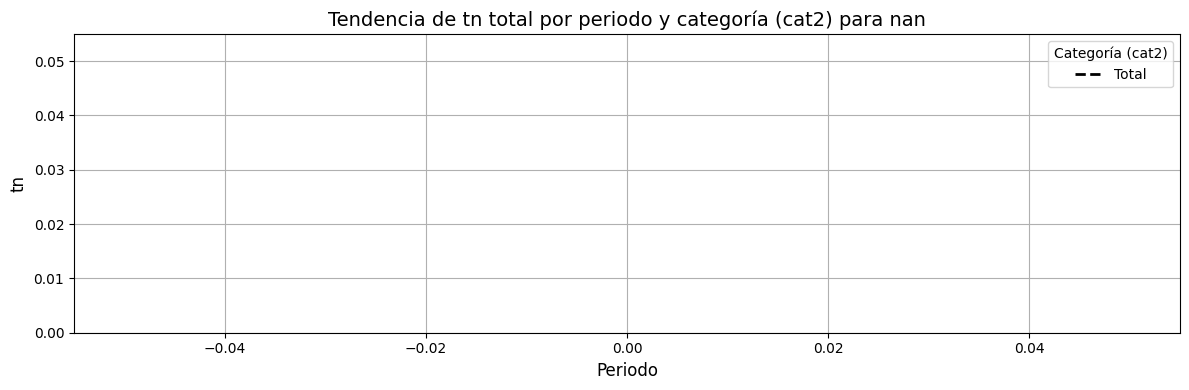

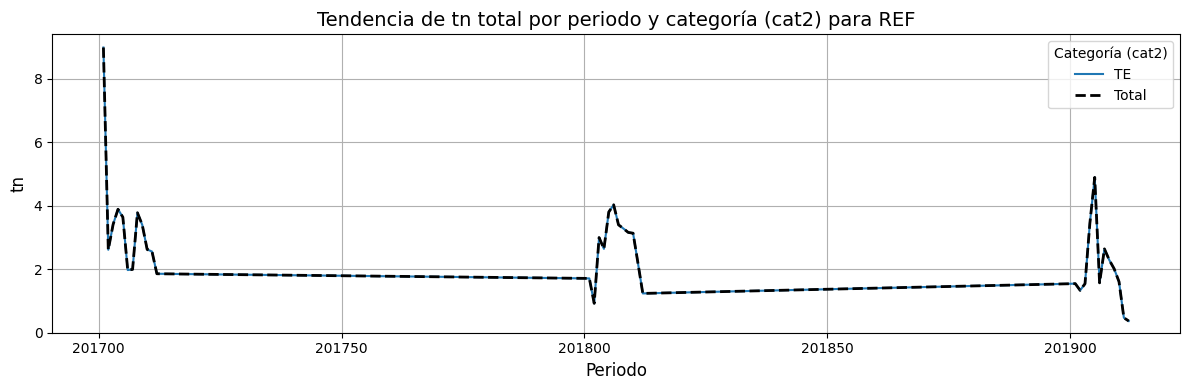

In [93]:
# Iterar sobre cada categoría en cat1
for cat1 in df_producto_cliente_raw['cat1'].unique():
    # Filtrar los datos para la categoría actual de cat1
    period_cat2_tn = df_producto_cliente_raw[df_producto_cliente_raw['cat1'] == cat1].groupby(['periodo', 'cat2'])['tn'].sum().reset_index()
    
    # Calcular el total de tn por periodo para la categoría actual de cat1
    period_total_tn = df_producto_cliente_raw[df_producto_cliente_raw['cat1'] == cat1].groupby('periodo')['tn'].sum().reset_index()
    
    # Crear el gráfico
    plt.figure(figsize=(12, 4))
    
    # Graficar una línea para cada categoría en cat2
    for cat2 in period_cat2_tn['cat2'].unique():
        data = period_cat2_tn[period_cat2_tn['cat2'] == cat2]
        plt.plot(data['periodo'], data['tn'], label=cat2)
    
    # Graficar la línea del total
    plt.plot(period_total_tn['periodo'], period_total_tn['tn'], label='Total', color='black', linewidth=2, linestyle='--')
    
    # Configurar etiquetas y título
    plt.title(f'Tendencia de tn total por periodo y categoría (cat2) para {cat1}', fontsize=14)
    plt.ylabel('tn', fontsize=12)
    plt.xlabel('Periodo', fontsize=12)
    plt.ylim(bottom=0)
    plt.legend(title='Categoría (cat2)')
    plt.grid(True)
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

In [94]:
def grafico_categoria_sum_byTn(categoria):
    plt.figure(figsize=(12, 6))
    for cat in df_producto_cliente_raw[categoria].unique():
        cat_data = df_producto_cliente_raw[df_producto_cliente_raw[categoria] == cat].groupby('periodo')['tn'].sum().reset_index() 
        plt.plot(cat_data['periodo'], cat_data['tn'], label=categoria)

    # Personalizar el gráfico
    plt.title(f'Evolución de Tn por {categoria}')
    plt.ylabel('Toneladas')
    plt.legend(title=categoria)
    plt.grid(True)
    plt.tight_layout()


    # Mostrar el gráfico
    plt.show()

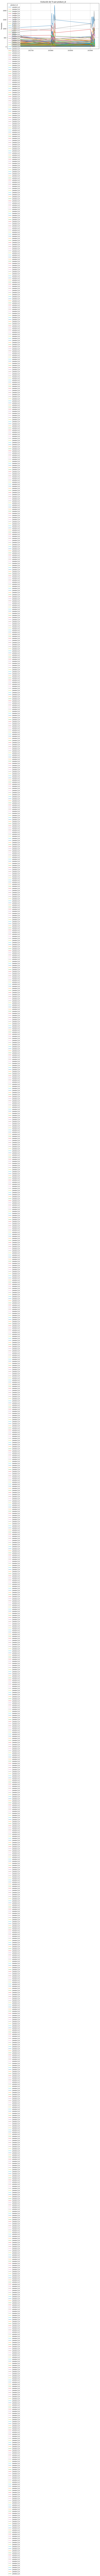

In [95]:
grafico_categoria_sum_byTn('product_id')

### ANALISIS POR CLIENTES

In [96]:
# 7. Top 10 clientes por tn acumulado
top_clients = df_producto_cliente_raw.groupby('customer_id')['tn'].sum().reset_index().sort_values('tn', ascending=False).head(10)


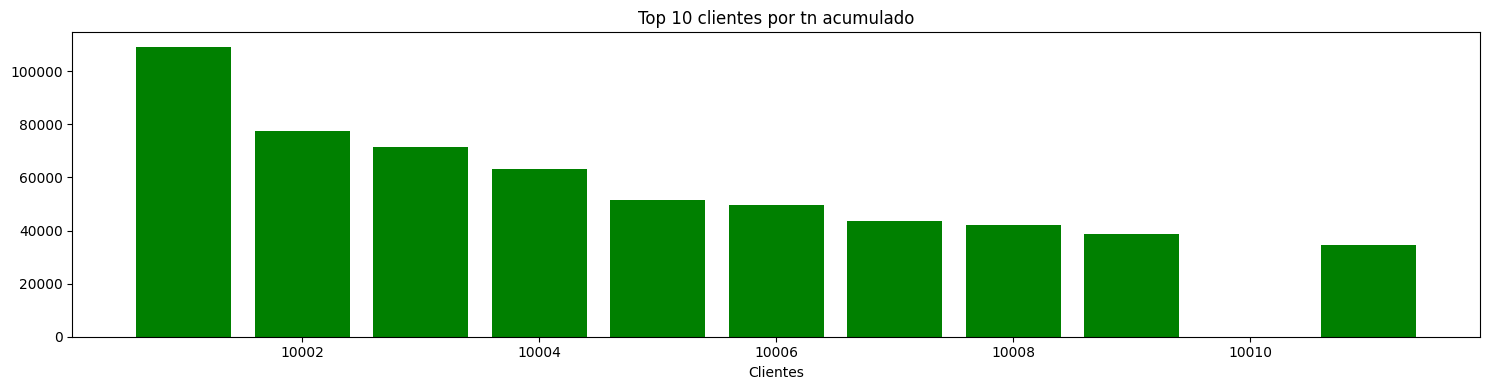

In [97]:

customers=top_clients['customer_id'].to_numpy()

plt.figure(figsize=(15, 4))
plt.bar(customers,top_clients['tn'],color='green')
plt.title('Top 10 clientes por tn acumulado')
plt.xlabel('Clientes')
plt.tight_layout()
plt.show()

In [98]:
top_10_tn = df_producto_cliente_raw.groupby('customer_id')['tn'].sum().nlargest(10)
total_tn = df_producto_cliente_raw['tn'].sum()
concentration = top_10_tn.sum() / total_tn * 100
print(f"Top 10 clientes concentran el {concentration:.2f}% del volumen total.")

Top 10 clientes concentran el 43.88% del volumen total.


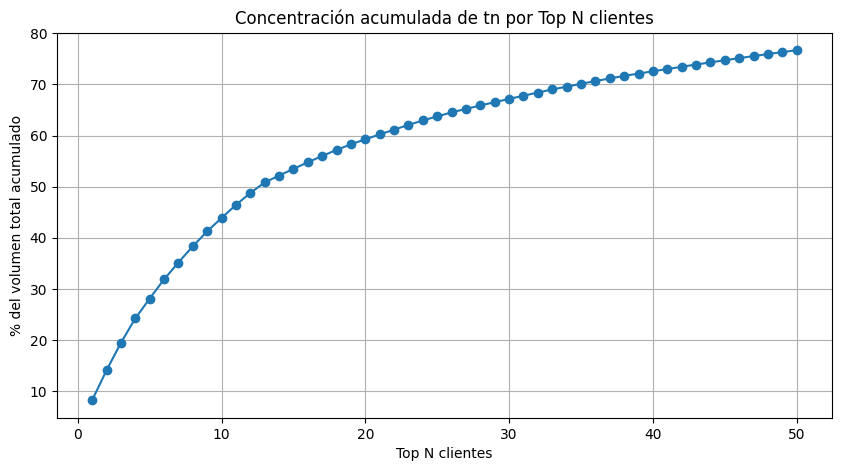

Top 10 clientes concentran el 43.88% del volumen total.
Top 15 clientes concentran el 53.47% del volumen total.
Top 20 clientes concentran el 59.26% del volumen total.
Top 25 clientes concentran el 63.74% del volumen total.
Top 30 clientes concentran el 67.16% del volumen total.
Top 40 clientes concentran el 72.56% del volumen total.
Top 50 clientes concentran el 76.68% del volumen total.


In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Agrupa y ordena clientes por tn acumulado
clientes_tn = df_producto_cliente_raw.groupby('customer_id')['tn'].sum().sort_values(ascending=False)
total_tn = clientes_tn.sum()

# Calcula concentración acumulada para distintos N
N_values = np.arange(1, 51)  # Top 1 a Top 50
concentration = [clientes_tn.iloc[:n].sum() / total_tn * 100 for n in N_values]

# Grafica
plt.figure(figsize=(10,5))
plt.plot(N_values, concentration, marker='o')
plt.xlabel('Top N clientes')
plt.ylabel('% del volumen total acumulado')
plt.title('Concentración acumulada de tn por Top N clientes')
plt.grid(True)
plt.show()

# Imprime algunos valores de referencia
for n in [10, 15, 20, 25, 30, 40, 50]:
    print(f"Top {n} clientes concentran el {concentration[n-1]:.2f}% del volumen total.")

In [100]:
# Calcula el ranking de clientes por tn acumulado
clientes_tn = df_producto_cliente_raw.groupby('customer_id')['tn'].sum().sort_values(ascending=False)

# Define los distintos top N que quieres analizar
top_n_values = [10, 15, 20, 25, 30, 40, 50]

# DataFrame para guardar resultados
resultados = []

for n in top_n_values:
    top_clientes = clientes_tn.index[:n]
    df_top = df_producto_cliente_raw[df_producto_cliente_raw['customer_id'].isin(top_clientes)]
    # Series únicas cliente-producto
    n_series = df_top.groupby(['customer_id', 'product_id']).size().reset_index().shape[0]
    # Porcentaje de filas del dataset original
    porcentaje_filas = len(df_top) / len(df_producto_cliente_raw) * 100
    resultados.append({
        'top_n': n,
        'n_series': n_series,
        'porcentaje_filas': porcentaje_filas,
        'clientes': list(top_clientes)
    })

# Convierte a DataFrame para visualizar
df_resultados = pd.DataFrame(resultados)
print(df_resultados[['top_n', 'n_series', 'porcentaje_filas']])

   top_n  n_series  porcentaje_filas
0     10      8690          6.832873
1     15     13186          9.515150
2     20     18052         12.533089
3     25     23049         14.735601
4     30     27597         17.226081
5     40     37072         20.851696
6     50     45616         24.133229


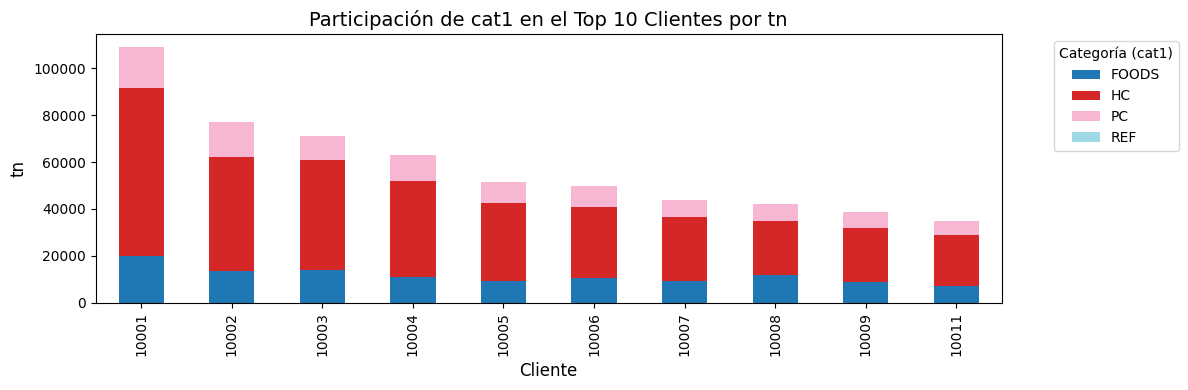

In [101]:
# Filtrar los datos para los clientes en el top 10
top_clients_ids = top_clients['customer_id']
df_top_clients = df_producto_cliente_raw[df_producto_cliente_raw['customer_id'].isin(top_clients_ids)]

# Agrupar por cliente y cat1, y calcular la suma de tn
stacked_data = df_top_clients.groupby(['customer_id', 'cat1'])['tn'].sum().unstack(fill_value=0)

# Crear el gráfico de barras apiladas
stacked_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 4),
    colormap='tab20'
)

# Configurar etiquetas y título
plt.title('Participación de cat1 en el Top 10 Clientes por tn', fontsize=14)
plt.xlabel('Cliente', fontsize=12)
plt.ylabel('tn', fontsize=12)
plt.legend(title='Categoría (cat1)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

### ANALISIS POR PRODUCTOS

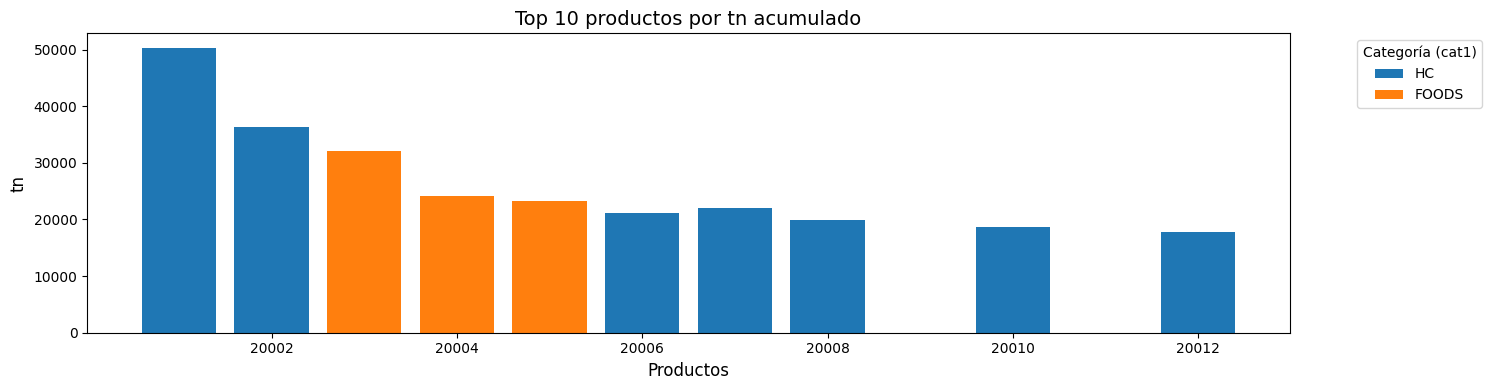

In [102]:
# Obtener los datos del top 10 productos con su categoría cat1
top_products = df_producto_cliente_raw.groupby(['product_id', 'cat1'])['tn'].sum().reset_index()
top_products = top_products.sort_values('tn', ascending=False).head(10)

# Crear un mapeo de colores para cada categoría de cat1
unique_cat1 = top_products['cat1'].unique()
color_map = {cat: color for cat, color in zip(unique_cat1, plt.cm.tab10.colors)}

# Crear el gráfico de barras con colores por cat1
plt.figure(figsize=(15, 4))
for i, row in top_products.iterrows():
    plt.bar(row['product_id'], row['tn'], color=color_map[row['cat1']], label=row['cat1'] if row['cat1'] not in plt.gca().get_legend_handles_labels()[1] else "")

# Configurar etiquetas y título
plt.title('Top 10 productos por tn acumulado', fontsize=14)
plt.xlabel('Productos', fontsize=12)
plt.ylabel('tn', fontsize=12)
plt.legend(title='Categoría (cat1)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [103]:
# ---------------------------------------------------------------
# Función 1  ▸  curva de cobertura dentro de cada product_id
# ---------------------------------------------------------------
def build_coverage_table(
    df: pd.DataFrame,
    tn_col: str = "tn",
    cust_col: str = "customer_id",
    prod_col: str = "product_id",
):
    """
    Devuelve un DataFrame con:
        • product_id
        • customer_id
        • tn_sum  (toneladas totales de ese par en 36 m)
        • tn_share   (proporción sobre el total del producto)
        • tn_cumperc (cobertura acumulada ordenada desc.)
    """
    # toneladas totales por (cliente, producto)
    grp = (
        df.groupby([prod_col, cust_col], as_index=False)[tn_col]
          .sum()
          .rename(columns={tn_col: "tn_sum"})
    )

    # toneladas totales por producto
    prod_total = grp.groupby(prod_col)["tn_sum"].transform("sum")
    grp["tn_share"] = grp["tn_sum"] / prod_total

    # ordenar cada producto desc. y generar cobertura acumulada
    grp = grp.sort_values([prod_col, "tn_sum"], ascending=[True, False])
    grp["tn_cumperc"] = (
        grp.groupby(prod_col)["tn_share"]
           .cumsum()
    )
    return grp


# ---------------------------------------------------------------
# Función 2  ▸  filtrar al “núcleo” de cada producto
# ---------------------------------------------------------------
def filter_core_series(
    df: pd.DataFrame,
    coverage: pd.DataFrame,
    threshold: float = 0.95,
    cust_col: str = "customer_id",
    prod_col: str = "product_id",
):
    """
    • Mantiene pares cuyo tn_cumperc ≤ threshold
    • Devuelve df_core  +  un pequeño resumen impreso
    """
    keep_pairs = coverage.loc[coverage["tn_cumperc"] <= threshold,
                              [prod_col, cust_col]]

    df_core = (
        df.merge(keep_pairs, on=[prod_col, cust_col], how="inner")
    )

    # ───── resumen rápido ──────────────────────────────────────
    tot_tn_before = df["tn"].sum()
    tot_tn_after  = df_core["tn"].sum()
    pct_tn        = 100 * tot_tn_after / tot_tn_before

    print(f"\n🔍  Cobertura fijada en {threshold:.0%}")
    print(f"  ▸  Filas originales         : {len(df):,}")
    print(f"  ▸  Filas tras filtrado      : {len(df_core):,}")
    print(f"  ▸  Toneladas conservadas    : {tot_tn_after:,.0f} "
          f"({pct_tn:4.1f} % del total)")

    return df_core


# ---------------------------------------------------------------
# Ejemplo de uso
# ---------------------------------------------------------------

# 1) construir la tabla de cobertura
cov_table = build_coverage_table(out,
                                 tn_col="tn",
                                 cust_col="customer_id",
                                 prod_col="product_id")

In [104]:
cov_table.head()

,product_id,customer_id,tn_sum,tn_share,tn_cumperc
3,20001,10004,7740.341309,0.153760,0.153760
0,20001,10001,6347.964844,0.126101,0.279861
2,20001,10003,4162.772949,0.082692,0.362553
6,20001,10007,3947.179932,0.078410,0.440963
12,20001,10013,3772.145264,0.074933,0.515896


In [105]:
def coverage_summary(
    df: pd.DataFrame,
    coverage_tbl: pd.DataFrame,
    thresholds=(0.80, 0.85, 0.90, 0.95),
    tn_col="tn",
    cust_col="customer_id",
    prod_col="product_id",
):
    """
    Devuelve una tabla con el efecto de distintos umbrales de cobertura.
    --------------------------------------------------------------------
    • df             : dataframe completo (cartesiano o no), con tn
    • coverage_tbl   : resultado de `build_coverage_table` (contiene tn_cumperc)
    • thresholds     : iterables de cortes (0-1)
    """

    # toneladas globales de referencia
    tn_total = df[tn_col].sum()

    rows = []
    for thr in thresholds:
        keep_pairs = coverage_tbl.loc[coverage_tbl["tn_cumperc"] <= thr,
                                      [prod_col, cust_col]]

        df_k = df.merge(keep_pairs, how="inner",
                        on=[prod_col, cust_col], validate="m:1")

        rows.append({
            "threshold"      : f"{int(thr*100)} %",
            "pairs_kept"     : f"{len(keep_pairs):,}",
            "filas_kept"     : f"{len(df_k):,}",
            "pct_filas"      : f"{100*len(df_k)/len(df):4.1f} %",
            "tn_kept"        : f"{df_k[tn_col].sum():,.0f}",
            "pct_tn_kept"    : f"{100*df_k[tn_col].sum()/tn_total:4.1f} %",
        })

    summary = pd.DataFrame(rows)
    return summary


# ───── ejecución rápida ───────────────────────────────────────────────
summary_table = coverage_summary(df_cart, cov_table)
print(summary_table.to_string(index=False))

threshold pairs_kept filas_kept pct_filas   tn_kept pct_tn_kept
     80 %     31,510    596,107    26.0 %   894,363      79.7 %
     85 %     42,546    757,509    33.0 %   952,592      84.9 %
     90 %     60,280    990,735    43.2 % 1,009,294      89.9 %
     95 %     93,253  1,359,169    59.3 % 1,066,065      95.0 %


In [106]:
THR = 0.90   # puedes cambiar a 0.85, 0.95…

keep_pairs = (
    cov_table
    .loc[cov_table["tn_cumperc"] <= THR, ["customer_id", "product_id"]]
)

print(f"Conservamos {len(keep_pairs):,} pares únicos "
      f"({100*len(keep_pairs)/cov_table.shape[0]:.1f} % de las series)")

df_core = (
    df_cart
    .merge(keep_pairs, how="inner",
           on=["customer_id", "product_id"], validate="m:1")
)

print(f"Filas finales: {len(df_core):,}  "
      f"({100*len(df_core)/len(df_cart):.1f} % del dataset)")

Conservamos 60,280 pares únicos (22.9 % de las series)
Filas finales: 990,735  (43.2 % del dataset)


In [107]:
# guardo el dataset original por si se opta por hacer el producto cartesiano con todas las series, predecir y luego filtrar 780 ids de kaggle
df_producto_cliente_raw.to_parquet("df_raw.parquet", compression="zstd")

### Creación baseline (reg lineal)

In [108]:
# 1. Filtrar solo las filas de febrero de 2017, 2018 y 2019
mask = (
    (df_producto['timestamp'].dt.month == 2) &
    (df_producto['timestamp'].dt.year.isin([2017, 2018, 2019]))
)
df_feb = df_producto.loc[mask, ['product_id', 'timestamp', 'tn']]

# 2. Pivotear para tener columnas por año
df_feb_pivot = (
    df_feb
      .assign(year = df_feb['timestamp'].dt.year)
      .pivot(index='product_id', columns='year', values='tn')
)

# 3. Renombrar columnas
df_feb_pivot = df_feb_pivot.rename(columns={
    2017: 'feb-2017',
    2018: 'feb-2018',
    2019: 'feb-2019',
})

# 4. rellenar NaNs con 0 si falta alguna fila
df_feb_pivot = df_feb_pivot.fillna(0)

# 5. Calcular promedio
df_feb_pivot['prom'] = df_feb_pivot[['feb-2017','feb-2018','feb-2019']].mean(axis=1)

# 6. Resetear índice para tener product_id como columna
df_feb_yearly = df_feb_pivot.reset_index()

# Ver el resultado
df_feb_yearly.head()

year,product_id,feb-2017,feb-2018,feb-2019,prom
0,20001,798.016174,1043.764648,1259.093628,1033.624878
1,20002,505.886322,712.000854,1043.013550,753.633606
2,20003,752.115173,788.307495,758.326538,766.249695
3,20004,508.200439,503.653259,441.703308,484.519012
4,20005,551.430603,399.208801,409.899506,453.512970


In [109]:
df_si_step = df_sell_in.copy()
df_si_step['product_id'] = df_si_step['product_id'].astype(int)
df_si_step['periodo']    = df_si_step['periodo'].astype(int)
df_si_step['tn']         = df_si_step['tn'].astype(float)

# Agregación
df_prod_step1 = (
    df_si_step
      .groupby(['product_id', 'periodo'], as_index=False)
      .agg(tn=('tn', 'sum'))
      .sort_values(['product_id', 'periodo'])
      .reset_index(drop=True)
)

# ------------------------------------------------------------------
# Chequeos de control
# ------------------------------------------------------------------
tn_raw = df_si_step['tn'].sum()
tn_agg = df_prod_step1['tn'].sum()
print(f"✅ df_prod_step1 creado: {df_prod_step1.shape}")
print(f"   Suma tn raw : {tn_raw:,.6f}")
print(f"   Suma tn agg : {tn_agg:,.6f}")
print(f"   Dif (agg-raw): {tn_agg - tn_raw:,.6f}")

# Vista rápida
df_prod_step1.head()

✅ df_prod_step1 creado: (31243, 3)
   Suma tn raw : 1,324,988.588410
   Suma tn agg : 1,324,988.588410
   Dif (agg-raw): 0.000000


,product_id,periodo,tn
0,20001,201701,934.77222
1,20001,201702,798.01620
2,20001,201703,1303.35771
3,20001,201704,1069.96130
4,20001,201705,1502.20132


In [110]:
df_prod_step2 = df_prod_step1.copy()

# 1) periodo -> datetime mensual (primer día del mes)
df_prod_step2['periodo_dt'] = pd.to_datetime(df_prod_step2['periodo'].astype(str), format="%Y%m")

# 2) clave futuro = periodo + 2 meses
df_prod_step2['periodo_dt_p2'] = df_prod_step2['periodo_dt'] + pd.DateOffset(months=2)

# 3) tabla futura (para merge): tn en periodo_dt = clase del registro 2 meses antes
future_lookup = (
    df_prod_step2[['product_id', 'periodo_dt', 'tn']]
      .rename(columns={'periodo_dt': 'periodo_dt_p2', 'tn': 'clase'})
)

# 4) merge para traer tn del mes +2 como 'clase'
df_prod_step2 = df_prod_step2.merge(
    future_lookup,
    on=['product_id', 'periodo_dt_p2'],
    how='left'
)

# Control rápido: últimos meses deberían tener clase NaN
print(df_prod_step2[['product_id','periodo','tn','clase']].tail())

# Resultado:
df_prod_step2.head()

       product_id  periodo       tn  clase
31238       21295   201701  0.00699    NaN
31239       21296   201708  0.00651    NaN
31240       21297   201701  0.00579    NaN
31241       21298   201708  0.00573    NaN
31242       21299   201708  0.00546    NaN


,product_id,periodo,tn,periodo_dt,periodo_dt_p2,clase
0,20001,201701,934.77222,2017-01-01,2017-03-01,1303.35771
1,20001,201702,798.01620,2017-02-01,2017-04-01,1069.96130
2,20001,201703,1303.35771,2017-03-01,2017-05-01,1502.20132
3,20001,201704,1069.96130,2017-04-01,2017-06-01,1520.06539
4,20001,201705,1502.20132,2017-05-01,2017-07-01,1030.67391


In [111]:
df_prod_fe = df_prod_step2.copy()

# ─────────────────────────────────────────────────────────────
# 1) Normalizar índice mensual y construir calendario completo
#    (necesario para que los lags sean "mes a mes" reales;
#    si no, un hueco de meses se interpretaría como lag=1 erróneamente)
# ─────────────────────────────────────────────────────────────
# Rango global en los datos
dt_min = df_prod_fe['periodo_dt'].min()
dt_max = df_prod_fe['periodo_dt'].max()

months_full = pd.date_range(start=dt_min, end=dt_max, freq='MS')
prod_ids    = df_prod_fe['product_id'].unique()

# base calendario completo producto × mes
base = (
    pd.MultiIndex.from_product([prod_ids, months_full],
                               names=['product_id','periodo_dt'])
      .to_frame(index=False)
)

# merge con datos reales (mantiene todos los meses; tn/clase NaN donde no hubo registro)
df_prod_fe = base.merge(
    df_prod_fe[['product_id','periodo_dt','tn','clase']],
    on=['product_id','periodo_dt'],
    how='left'
)

# reconstruir columna periodo (YYYYMM int) para referencia
df_prod_fe['periodo'] = df_prod_fe['periodo_dt'].dt.strftime('%Y%m').astype(int)

# ─────────────────────────────────────────────────────────────
# 2) LAGS mensuales tn_1 .. tn_11  (NaN si no hay historia suficiente)
# ─────────────────────────────────────────────────────────────
df_prod_fe = df_prod_fe.sort_values(['product_id','periodo_dt'])

for k in range(1, 12):  # 1..11
    df_prod_fe[f'tn_{k}'] = (
        df_prod_fe.groupby('product_id')['tn']
                  .shift(k)
    )

# ─────────────────────────────────────────────────────────────
# 3) Medias de “últimos meses”
#    Elegimos 2 tipos básicos:
#      • tn_mean_hist: media acumulada hasta el mes anterior (evita mirar el mes corriente)
#      • tn_mean_12  : media rolling 12 meses (incluye mes actual; min_periods=1)
#    Ambas ignoran NaN automáticamente.
# ─────────────────────────────────────────────────────────────
# Media acumulada EXCLUYENDO el mes actual (para no “filtrar” su propio valor
# si querés puro pasado). Usamos cumsum / cumcount sobre tn rellenando 0 en NaN.
grp = df_prod_fe.groupby('product_id', group_keys=False)

# Para acumular correctamente ignorando NaNs:
def _expanding_mean_excl_cur(s):
    # s es tn; necesitamos suma hasta t-1 y count hasta t-1
    # desplazamos 1 lugar
    s_valid = s.copy()
    # mascar NaNs
    notna = s_valid.notna()
    csum  = (s_valid.fillna(0).cumsum() - s_valid.fillna(0)).shift(1, fill_value=0)
    # count acumulado de válidos hasta t-1
    ccount = (notna.cumsum() - notna.astype(int)).shift(1, fill_value=0)
    # mean
    out = csum / ccount.replace(0, np.nan)
    return out

df_prod_fe['tn_mean_hist'] = grp['tn'].apply(_expanding_mean_excl_cur)

# Rolling 12 (incluye mes actual; ajustá si lo querés excluyendo)
df_prod_fe['tn_mean_12'] = (
    grp['tn'].apply(lambda s: s.rolling(window=12, min_periods=1).mean())
)

# ─────────────────────────────────────────────────────────────
# 4) Orden final + controles
# ─────────────────────────────────────────────────────────────
df_prod_fe = df_prod_fe.sort_values(['product_id','periodo_dt']).reset_index(drop=True)

print("✅ Feature engineering completado.")
print("Columnas:", df_prod_fe.columns.tolist())
print(df_prod_fe.head(15))
print("\nChequeo NaNs por columna:")
print(df_prod_fe.isna().mean().sort_values(ascending=False).head(15))

✅ Feature engineering completado.
Columnas: ['product_id', 'periodo_dt', 'tn', 'clase', 'periodo', 'tn_1', 'tn_2', 'tn_3', 'tn_4', 'tn_5', 'tn_6', 'tn_7', 'tn_8', 'tn_9', 'tn_10', 'tn_11', 'tn_mean_hist', 'tn_mean_12']
    product_id periodo_dt          tn       clase  periodo        tn_1  \
0        20001 2017-01-01   934.77222  1303.35771   201701         NaN   
1        20001 2017-02-01   798.01620  1069.96130   201702   934.77222   
2        20001 2017-03-01  1303.35771  1502.20132   201703   798.01620   
3        20001 2017-04-01  1069.96130  1520.06539   201704  1303.35771   
4        20001 2017-05-01  1502.20132  1030.67391   201705  1069.96130   
5        20001 2017-06-01  1520.06539  1267.39462   201706  1502.20132   
6        20001 2017-07-01  1030.67391  1316.94604   201707  1520.06539   
7        20001 2017-08-01  1267.39462  1439.75563   201708  1030.67391   
8        20001 2017-09-01  1316.94604  1580.47401   201709  1267.39462   
9        20001 2017-10-01  1439.75563  10

In [112]:
PERIODO_REF = 201812        # mes que usamos como "X" (dic-2018)
HORIZON_P2  = 2             # clase = tn en +2 meses (feb-2019)
MAGICOS = [20002, 20003, 20006, 20010, 20011, 20018, 20019, 20021,
           20026, 20028, 20035, 20039, 20042, 20044, 20045, 20046,
           20049, 20051, 20052, 20053, 20055, 20008, 20001, 20017,
           20086, 20180, 20193, 20320, 20532, 20612, 20637, 20807, 20838]

# ==============================================================
# 1) Asegurar que df_prod_fe existe (mensual densificado)
#    y que contiene al menos: product_id, periodo_dt, periodo, tn, tn_1..tn_11
# ==============================================================
df_prod_fe_step = df_prod_fe.copy()

# sanity sort
df_prod_fe_step = df_prod_fe_step.sort_values(['product_id','periodo_dt']).reset_index(drop=True)

# ==============================================================
# 2) Recalcular clase = tn en periodo_dt + 2 meses (shift -2)
#    Lo hacemos siempre para evitar arrastrar cálculos previos incompletos.
# ==============================================================
df_prod_fe_step['clase'] = (
    df_prod_fe_step.groupby('product_id')['tn'].shift(-HORIZON_P2)
)

# ==============================================================
# 3) Subset: mes de referencia (PERIODO_REF) + product_id mágicos
# ==============================================================
df_sub = df_prod_fe_step.loc[
    (df_prod_fe_step['periodo'] == PERIODO_REF) &
    (df_prod_fe_step['product_id'].isin(MAGICOS))
].copy()

# ==============================================================
# 4) Seleccionar columnas de entrada (tn + 11 lags) y objetivo
# ==============================================================
lag_cols = ['tn'] + [f'tn_{k}' for k in range(1, 12)]
cols_needed = ['product_id','periodo','clase'] + lag_cols

missing_cols = [c for c in cols_needed if c not in df_sub.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas requeridas en df_sub: {missing_cols}")

# ==============================================================
# 5) Filtrar filas con datos completos (sin NaN en X ni y)
# ==============================================================
df_sub_clean = df_sub.dropna(subset=lag_cols + ['clase']).copy()

# ==============================================================
# 6) Reporte
# ==============================================================
print(f"➡️  dataset_training (antes de drop NaN): {df_sub.shape}")
print(f"➡️  dataset_training (sin NaNs en tn..tn_11 + clase): {df_sub_clean.shape}")

# cuántos de los mágicos se conservaron
present_magicos = set(df_sub_clean['product_id'].unique())
missing_magicos = [pid for pid in MAGICOS if pid not in present_magicos]

print(f"\n✔️ Productos mágicos presentes con datos completos: {len(present_magicos)} / {len(MAGICOS)}")
if missing_magicos:
    print(f"⚠️ Faltan {len(missing_magicos)} mágicos SIN datos completos o sin clase:")
    print(missing_magicos)

# vista rápida
display(df_sub_clean[['product_id','periodo','clase'] + lag_cols].head())

# Guardar (opcional, comenta si no querés aún)
dataset_training = df_sub_clean[['product_id','periodo','clase'] + lag_cols].reset_index(drop=True)
# dataset_training.to_parquet("data/dataset_training_reglin.parquet", index=False, compression="zstd")

➡️  dataset_training (antes de drop NaN): (33, 18)
➡️  dataset_training (sin NaNs en tn..tn_11 + clase): (33, 18)

✔️ Productos mágicos presentes con datos completos: 33 / 33


,product_id,periodo,clase,tn,tn_1,tn_2,tn_3,tn_4,tn_5,tn_6,tn_7,tn_8,tn_9,tn_10,tn_11
23,20001,201812,1259.09363,1486.68669,1813.01511,2295.19832,1438.67455,1800.96168,1470.41009,1150.79169,1293.89788,1251.28462,1856.83534,1043.76470,1169.07532
59,20002,201812,1043.01349,1009.45458,1766.81068,1378.49032,954.23575,1161.88430,977.40239,1033.82845,1103.39191,999.20934,966.86044,712.00087,984.80167
95,20003,201812,758.32657,769.82869,1206.91773,1313.34211,912.34156,955.97079,656.22700,660.73323,784.35885,765.47838,778.55594,788.30749,907.56304
203,20006,201812,479.99914,407.75925,566.66809,513.15472,478.04388,615.70617,515.20419,468.15260,865.28861,748.44391,862.19361,588.56272,470.33785
275,20008,201812,476.98787,426.32899,433.50170,532.45644,436.96269,554.82147,526.38149,554.57063,707.59267,691.53246,765.98901,506.25385,469.29224


In [113]:
INTERCEPT = 0.441467

COEFS = {
    'tn'   : -0.001339,
    'tn_1' :  0.236558,
    'tn_2' :  0.178208,
    'tn_3' : -0.060031,
    'tn_4' : -0.161875,
    'tn_5' : -0.007775,
    'tn_6' :  0.151936,
    'tn_7' :  0.043933,
    'tn_8' :  0.142839,
    'tn_9' :  0.103804,
    'tn_10':  0.119211,
    'tn_11':  0.073671,
}

In [114]:
df_score_780 = (
    df_score[df_score['product_id'].isin(productos_a_predecir)]
      .copy()
      .reset_index(drop=True)
)

print(f"df_score_780: {df_score_780.shape} (esperado ~780 filas)")

# ------------------------------------------------------------
# 1) Definir columnas (orden importa para los coeficientes)
# ------------------------------------------------------------
lag_cols = ['tn'] + [f'tn_{k}' for k in range(1, 12)]

# ------------------------------------------------------------
# 2) Máscara: fila completa (los 12 valores no NaN)
# ------------------------------------------------------------
mask_complete = df_score_780[lag_cols].notna().all(axis=1)
print(f"Completos: {mask_complete.sum()} / {len(df_score_780)}")

# ------------------------------------------------------------
# 3) Predicción regresión lineal (solo completos)
# ------------------------------------------------------------
beta = np.array([COEFS[c] for c in lag_cols], dtype=float)
X = df_score_780.loc[mask_complete, lag_cols].astype(float).values
y_hat = INTERCEPT + X.dot(beta)

df_score_780['pred'] = np.nan
df_score_780.loc[mask_complete, 'pred'] = y_hat

# ------------------------------------------------------------
# 4) Fallback = promedio últimos 12 meses (ya en fallback_mean12)
#    • si falta fallback_mean12 (por seguridad) lo recalculamos
# ------------------------------------------------------------
if 'fallback_mean12' not in df_score_780.columns:
    df_score_780['fallback_mean12'] = df_score_780[lag_cols].mean(axis=1, skipna=True)

# Fallback cuando incompleto
df_score_780.loc[~mask_complete, 'pred'] = (
    df_score_780.loc[~mask_complete, 'fallback_mean12'].astype(float)
)

# Si todavía queda algún NaN (casos extremos), setear a 0
df_score_780['pred'] = df_score_780['pred'].fillna(0.0)

# No negativos
df_score_780['pred'] = df_score_780['pred'].clip(lower=0)

# ------------------------------------------------------------
# 5) Resumen completitud + sumas tn 201912
# ------------------------------------------------------------
df_score_780['completitud'] = np.where(mask_complete, 'completos', 'INcompletos')

summary = (
    df_score_780.groupby('completitud', as_index=False)
                .agg(
                    registros=('product_id','size'),
                    tn_a_201912=('tn','sum')
                )
)

# Ordenar salida
cat = pd.CategoricalDtype(categories=['completos','INcompletos'], ordered=True)
summary['completitud'] = summary['completitud'].astype(cat)
summary = summary.sort_values('completitud').reset_index(drop=True)

print("\n=== Campos Completos ===")
print(summary)

# ------------------------------------------------------------
# 6) Dataset final Kaggle
# ------------------------------------------------------------
submission_reglin = (
    df_score_780[['product_id','pred']]
      .rename(columns={'pred':'tn'})
      .sort_values('product_id')
      .reset_index(drop=True)
)

print(f"\n✅ submission_reglin listo: {len(submission_reglin)} productos.")
print(f"   Suma total pred tn: {submission_reglin['tn'].sum():,.2f}")

submission_reglin.to_csv("submission_reglin.csv", index=False)
print("💾 Guardado: submission_reglin.csv")

# Vista rápida (primeras filas)
submission_reglin.head()

df_score_780: (780, 15) (esperado ~780 filas)
Completos: 650 / 780

=== Campos Completos ===
   completitud  registros  tn_a_201912
0    completos        650  23439.27676
1  INcompletos        130   1705.97532

✅ submission_reglin listo: 780 productos.
   Suma total pred tn: 27,997.26
💾 Guardado: submission_reglin.csv


,product_id,tn
0,20001,1162.705930
1,20002,1183.639540
2,20003,684.763159
3,20004,580.484232
4,20005,563.559924


In [115]:
submission_reglin.to_parquet("baseline.parquet", compression="zstd")